# 循环神经网络从零实现

In [16]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## 独热编码

In [17]:
# 使用 PyTorch 中的 F.one_hot 函数将给定的索引序列转换为 one-hot 编码
# torch.tensor([0,2]) 表示要编码的索引序列，len(vocab) 表示词汇表的长度
F.one_hot(torch.tensor([0,2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [18]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

## 初始化模型参数
<img src="./image/8.5_1RNN.png" width=600>

In [19]:
def get_params(vocab_size, num_hinddens, device):
    # 设置输入和输出的维度为词汇表的大小
    num_inputs = num_outputs = vocab_size

    # 定义一个用于生成服从正态分布的随机数的函数
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 初始化权重矩阵 W_xh 和 W_hh，以及偏置向量 b_h
    W_xh = normal((num_inputs, num_hinddens))  # 输入到隐藏层的权重矩阵
    W_hh = normal((num_hinddens, num_hinddens))  # 隐藏层到隐藏层的权重矩阵
    b_h = torch.zeros(num_hinddens, device=device)  # 隐藏层的偏置向量

    # 初始化权重矩阵 W_hq 和偏置向量 b_q
    W_hq = normal((num_hinddens, num_outputs))  # 隐藏层到输出层的权重矩阵
    b_q = torch.zeros(num_outputs, device=device)  # 输出层的偏置向量

    # 将所有参数放入列表中
    params = [W_xh, W_hh, b_h, W_hq, b_q]

    # 设置所有参数的梯度可求
    for param in params:
        param.requires_grad_(True)
    return params


## 循环神经网络模型

In [20]:
def init_rnn_state(batch_size, num_hiddens, device):
    # 初始化 RNN 的隐藏状态为全零张量
    return (torch.zeros((batch_size, num_hiddens), device=device),)

def rnn(inputs, state, params):
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        # 计算当前时刻的隐藏状态
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        # 计算当前时刻的输出
        Y = torch.mm(H, W_hq) + b_q
        # 将输出添加到输出列表
        outputs.append(Y)
    # 将所有输出连接起来，并返回最终的输出张量和最终的隐藏状态
    return torch.cat(outputs, dim=0), (H,)


In [21]:
class RNNModelScratch:
    def __init__(self, vocab_size, num_hiddens, device, get_params, init_state, forward_fn):
        self.vocab_size, self.num_hinddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        # 初始化隐藏状态的函数
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        # 调用前向传播函数计算输出和最终隐藏状态
        return self.forward_fn(X, state, self.params)
    
    def begin_state(self, batch_size, device):
        # 初始化初始的隐藏状态
        return self.init_state(batch_size, self.num_hinddens, device)


In [22]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params, init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [23]:
def predict_ch8(prefix, num_preds, net, vocab, device):
    state = net.begin_state(batch_size=1, device=device)
    # 将前缀的第一个字符加入到输出列表中
    outputs = [vocab[prefix[0]]]
    # 定义一个函数用于获取输入数据
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    # 对前缀序列进行迭代
    for y in prefix[1:]:
        # 使用前一个字符更新隐藏状态
        _, state = net(get_input(), state)
        # 将当前字符加入到输出列表中
        outputs.append(vocab[y])
    # 生成预测序列
    for _ in range(num_preds):
        # 预测下一个字符并更新隐藏状态
        y, state = net(get_input(), state)
        # 将预测结果（最大概率值）加入到输出列表中
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    # 将输出列表中的索引转换为相应的字符
    return ''.join([vocab.idx_to_token[i] for i in outputs])

predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())


'time traveller lncvimncvi'

In [24]:
# 解决梯度爆炸问题
def grad_clipping(net, theta):
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    # 计算梯度的 L2 范数
    norm = torch.sqrt(sum(torch.sum(p.grad ** 2) for p in params))
    # 如果梯度的 L2 范数超过了阈值 theta，进行梯度裁剪，使得整体的梯度 L2 范数不超过阈值 theta
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [25]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    state, timer = None, d2l.Timer()
    mertric = d2l.Accumulator(2)
    for X, Y in train_iter:
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        # 将数据传输到指定设备
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        # 执行前向传播操作并计算损失
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        # 根据不同的更新器执行参数更新操作
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()  # 清除之前的梯度
            l.backward()  # 计算梯度
            grad_clipping(net, 1)  # 执行梯度裁剪
            updater.step()  # 更新模型参数
        else:
            l.backward()
            grad_clipping(net, 1)  # 执行梯度裁剪
            updater(batch_size=1)
        # 更新度量器
        mertric.add(l * y.numel(), y.numel())
    # 返回本 epoch 的困惑度和每秒处理样本数
    return math.exp(mertric[0] / mertric[1]), mertric[1] / timer.stop()

In [26]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity', legend=['train'], xlim=[10, num_epochs])
    # 根据网络类型选择不同的更新器
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters, lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    # 定义一个用于预测的函数
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    for epoch in range(num_epochs):
        # 训练一个 epoch 并返回困惑度和每秒处理的样本数
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
        # 每隔 10 个 epoch 输出一次预测结果
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1.0, 38504.7 词元/秒 cpu
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


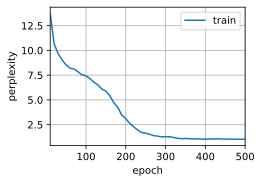

In [12]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

困惑度 1.3, 39101.3 词元/秒 cpu
time traveller but now you begin to seethe object of my investig
traveller but now you begin to seethe object of my investig


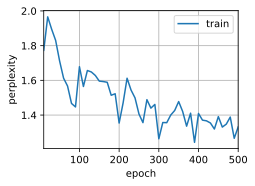

In [13]:
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(), use_random_iter=True)

# 循环网络的简洁实现

In [31]:
batch_size, num_staeps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps, use_random_iter=True)

In [32]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

In [33]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [34]:
X = torch.rand((num_steps, batch_size, len(vocab)))
Y, new_state = rnn_layer(X, state)
Y.shape, new_state.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [39]:
class RNNModel(nn.Module):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super().__init__(**kwargs)
        self.rnn = rnn_layer  # 设置 RNN 层
        self.vocab_size = vocab_size  # 词汇表大小
        self.num_hiddens = self.rnn.hidden_size  # 隐藏层单元数量

        # 根据 RNN 是否为双向设置线性层
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)
    
    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)  # 对输入进行 one-hot 编码
        X = X.to(torch.float32)  # 转换为 float32 类型
        Y, state = self.rnn(X, state)  # 前向传播计算
        output = self.linear(Y.reshape((-1, Y.shape[-1])))  # 线性层计算输出
        return output, state  # 返回输出和隐藏状态
    
    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):  # 如果不是 LSTM 层
            return torch.zeros((self.num_directions * self.rnn.num_layers, batch_size, self.num_hiddens), device=device)  # 返回全零的隐藏状态
        else:
            return (torch.zeros((self.num_directions * self.rnn.num_layers, batch_size, self.num_hiddens), device=device), torch.zeros((self.num_directions * self.rnn.num_layers, batch_size, self.num_hiddens), device=device))  # 返回全零的 LSTM 隐藏状态

In [40]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travellerphpvn lype'

困惑度 1.7, 86068.7 词元/秒 cpu
time traveller came back andfilby tried to tell us about a conju
traveller came back andfilby s anecdote collapsedthe thing 


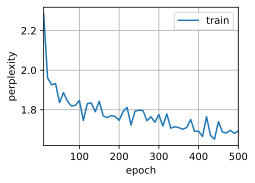

In [41]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)